# Importing the essential libraries

In [12]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from tqdm import tqdm
import scipy.io as sio
import urllib.request
import tarfile 

# Downloading the BSDS500 Dataset


In [13]:
# Download and extract BSDS500 dataset if not already present
def download_and_extract_dataset():
    dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
    tgz_file = "BSR_bsds500.tgz"
    
    if not os.path.exists('BSR'):
        print("Downloading BSDS500 dataset...")
        urllib.request.urlretrieve(dataset_url, tgz_file)
        
        print("Extracting dataset...")
        with tarfile.open(tgz_file, 'r:gz') as tar:
            tar.extractall()
        print("Dataset extracted successfully!")

# To load the Ground Truth Edges

In [14]:
# Load ground truth edges from .mat file
def load_gt_edges(gt_path):
    gt_data = sio.loadmat(gt_path)
    # Get all annotators' segmentations and combine them
    num_annotators = gt_data['groundTruth'].shape[1]
    gt_edges = np.zeros((gt_data['groundTruth'][0, 0]['Boundaries'][0, 0].shape))
    
    for i in range(num_annotators):
        gt_edges += gt_data['groundTruth'][0, i]['Boundaries'][0, 0]
    
    # Binarize: any annotator marked as edge
    gt_edges = (gt_edges > 0).astype(np.float32)
    return gt_edges

# Code for Canny Edge Detection

In [15]:
# Apply Canny edge detection with different blurring parameters
def canny_edge_detection(img, low_threshold=50, high_threshold=150, sigma=1.0):
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    # Calculate kernel size based on sigma
    kernel_size = int(2 * np.ceil(3 * sigma) + 1)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma)
    
    # Run Canny edge detector
    edges = cv2.Canny(blurred, low_threshold, high_threshold)
    
    # Normalize to [0, 1]
    edges = edges / 255.0
    
    return edges

# Code for visualizing and comparing the results obtained

In [16]:
# Visualize and compare results
def visualize_results(img, gt_edges, canny_edges_list, sigma_values):
    num_sigmas = len(sigma_values)
    plt.figure(figsize=(15, 8))
    
    # Original image
    plt.subplot(2, num_sigmas + 1, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Ground truth
    plt.subplot(2, num_sigmas + 1, num_sigmas + 2)
    plt.imshow(gt_edges, cmap='gray')
    plt.title('Ground Truth Edges')
    plt.axis('off')
    
    # Canny results with different sigma values
    for i, (sigma, edges) in enumerate(zip(sigma_values, canny_edges_list)):
        plt.subplot(2, num_sigmas + 1, i + 2)
        plt.imshow(edges, cmap='gray')
        plt.title(f'Canny (σ={sigma})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('canny_comparison.png', dpi=300)
    plt.show() 

# Using precision, recall and f1 score to have better understanding

In [17]:
def calculate_metrics(ground_truth, canny_output):
    # Convert to binasry (0 or 1)
    gt = (ground_truth > 0).astype(np.float32)
    pred = (canny_output > 0).astype(np.float32)
    
    # Calculate TP, FP, FN
    true_pos = np.sum(gt * pred)
    false_pos = np.sum((1-gt) * pred)
    false_neg = np.sum(gt * (1-pred))
    
    # Calculate metrics
    precision = true_pos / (true_pos + false_pos + 1e-10)
    recall = true_pos / (true_pos + false_neg + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    
    return precision, recall, f1

# Main Function that builds the pipeline to implement canny edge detection sequentially by combining all the previous defined functions

In [33]:
# Main function
def main():
    # Download and extract dataset
    download_and_extract_dataset()
    
    # Define paths
    data_dir = 'BSR/BSDS500/data'
    images_dir = os.path.join(data_dir, 'images', 'test')
    gt_dir = os.path.join(data_dir, 'groundTruth', 'test')
    
    # Get list of test images
    image_paths = glob.glob(os.path.join(images_dir, '*.jpg'))
    
    # Select a sample image for demonstration
    sample_idx = 0  # Change this to try different images
    img_path = image_paths[sample_idx]
    img_name = os.path.basename(img_path).split('.')[0]
    gt_path = os.path.join(gt_dir, f'{img_name}.mat')
    
    # Load image and ground truth
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gt_edges = load_gt_edges(gt_path)
    
    # Apply Canny with different sigma values
    sigma_values = [1.0, 2.0, 3.0]
    canny_edges_list = []
    metrics = []
    
    for sigma in sigma_values:
        edges = canny_edge_detection(img, low_threshold=50, high_threshold=150, sigma=sigma)
        canny_edges_list.append(edges)
        precision, recall, f1 = calculate_metrics(gt_edges, edges)
        metrics.append((sigma, precision, recall, f1))
        print(f"Sigma {sigma}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    # Plot precision-recall curve
    plt.figure(figsize=(10, 6))
    plt.scatter([m[2] for m in metrics], [m[1] for m in metrics], s=100)
    for i, m in enumerate(metrics):
        plt.annotate(f"σ={m[0]}", (m[2], m[1]), xytext=(10, 10), textcoords='offset points')
    plt.plot([m[2] for m in metrics], [m[1] for m in metrics], 'b--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Trade-off for Different Sigma Values')
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.savefig('canny_precision_recall.png')
    plt.show()
    
    print("\nShowing the results as comparison to ground truth and the image...")
    for i in range(min(6, len(image_paths))):
        img_path = image_paths[i]
        img_name = os.path.basename(img_path).split('.')[0]
        gt_path = os.path.join(gt_dir, f'{img_name}.mat')

        # Load image and ground truth
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gt_edges = load_gt_edges(gt_path)
        
        # Apply Canny with different sigma values
        canny_edges_list = []
        for sigma in sigma_values:
            edges = canny_edge_detection(img, low_threshold=50, high_threshold=150, sigma=sigma)
            canny_edges_list.append(edges)
        
        # Visualize results
        visualize_results(img, gt_edges, canny_edges_list, sigma_values)
    

Sigma 1.0: Precision=0.1163, Recall=0.2066, F1=0.1489
Sigma 2.0: Precision=0.2136, Recall=0.0981, F1=0.1345
Sigma 3.0: Precision=0.3400, Recall=0.0630, F1=0.1064


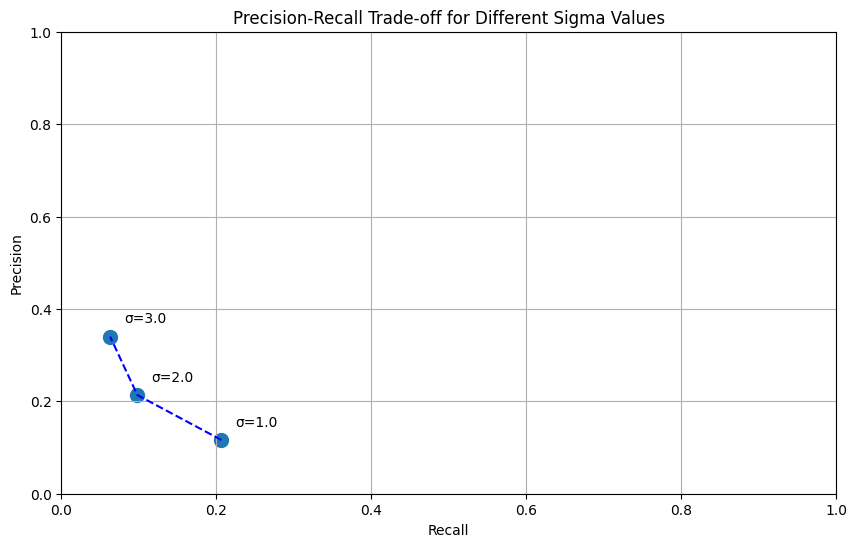


Showing the results as comparison to ground truth and the image...


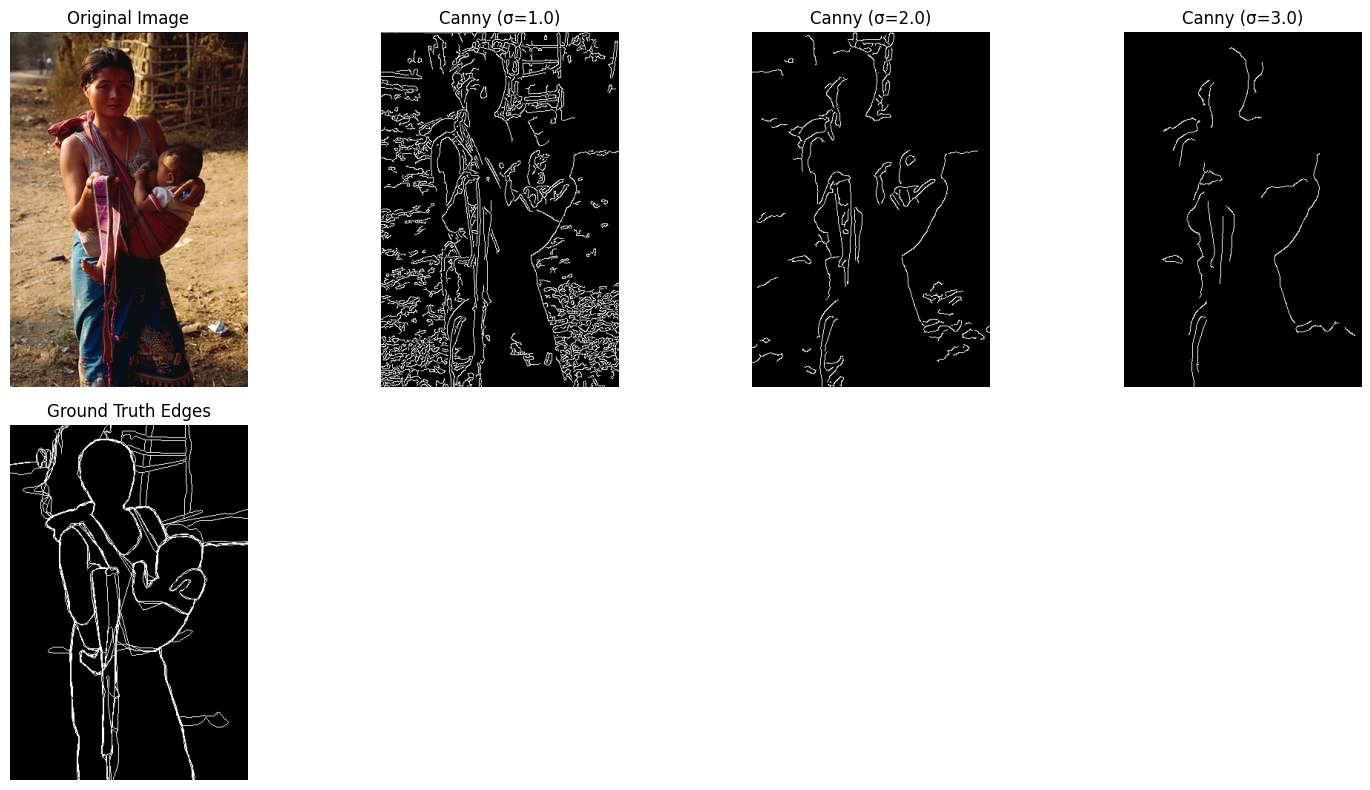

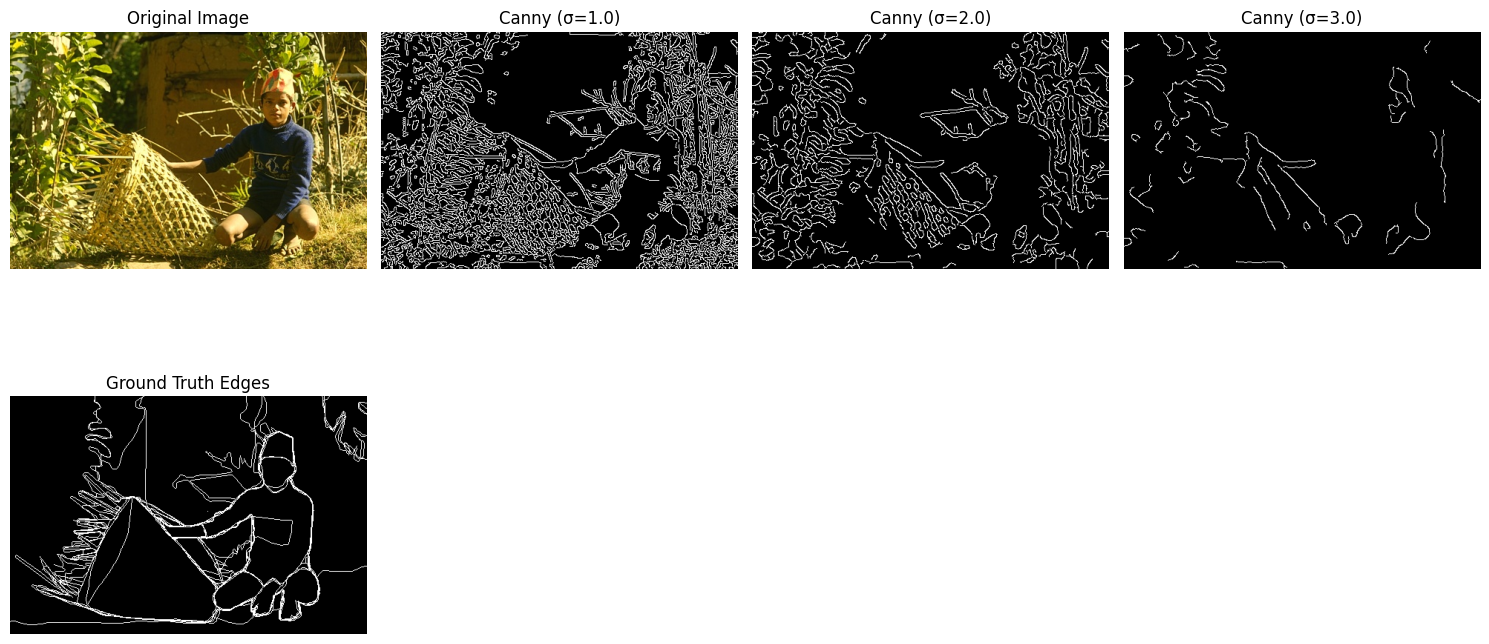

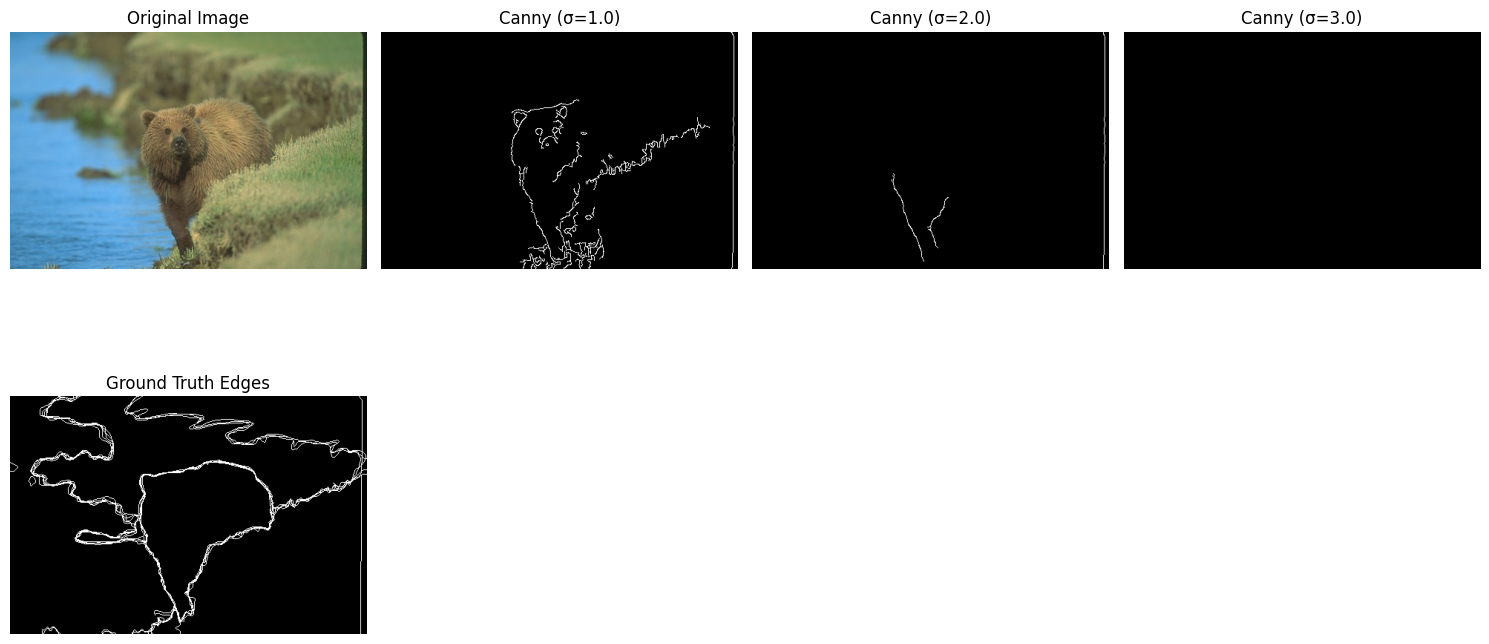

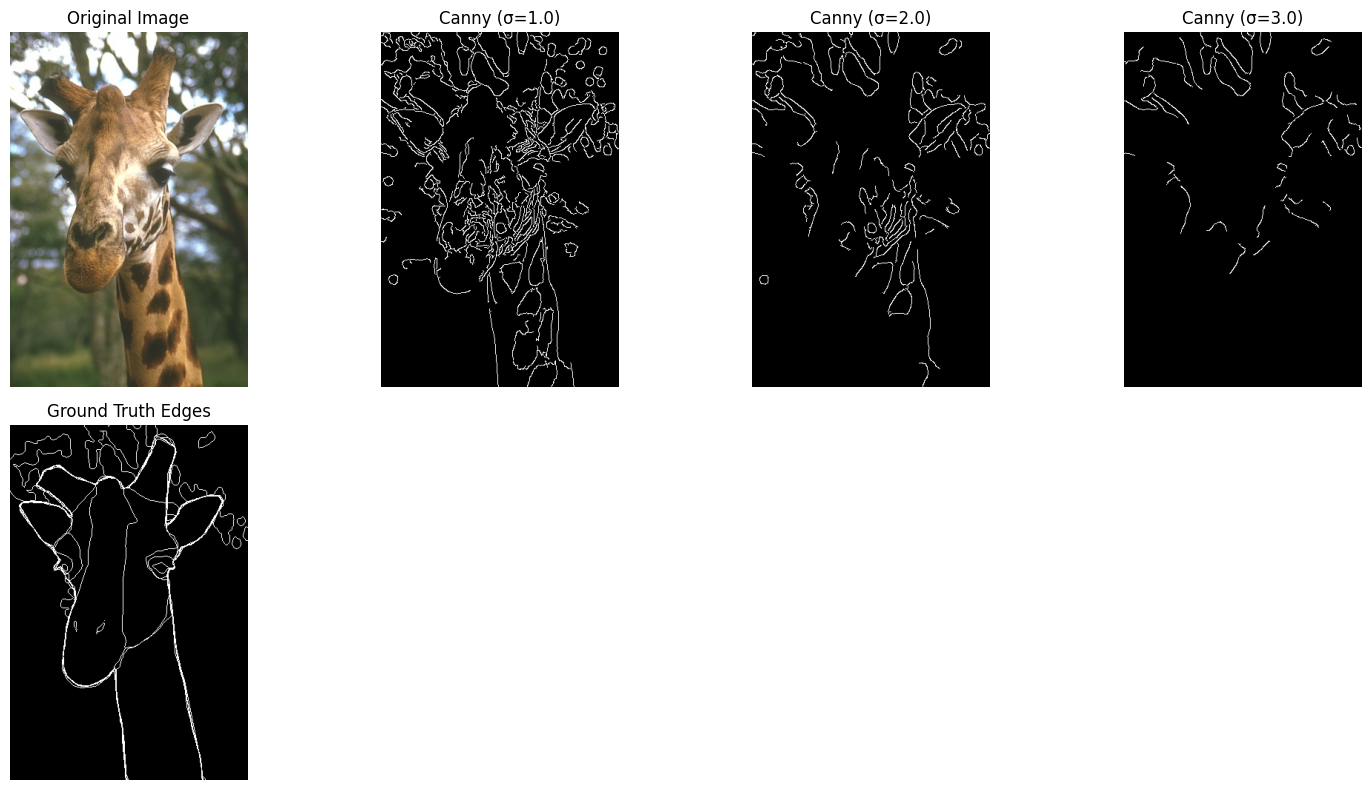

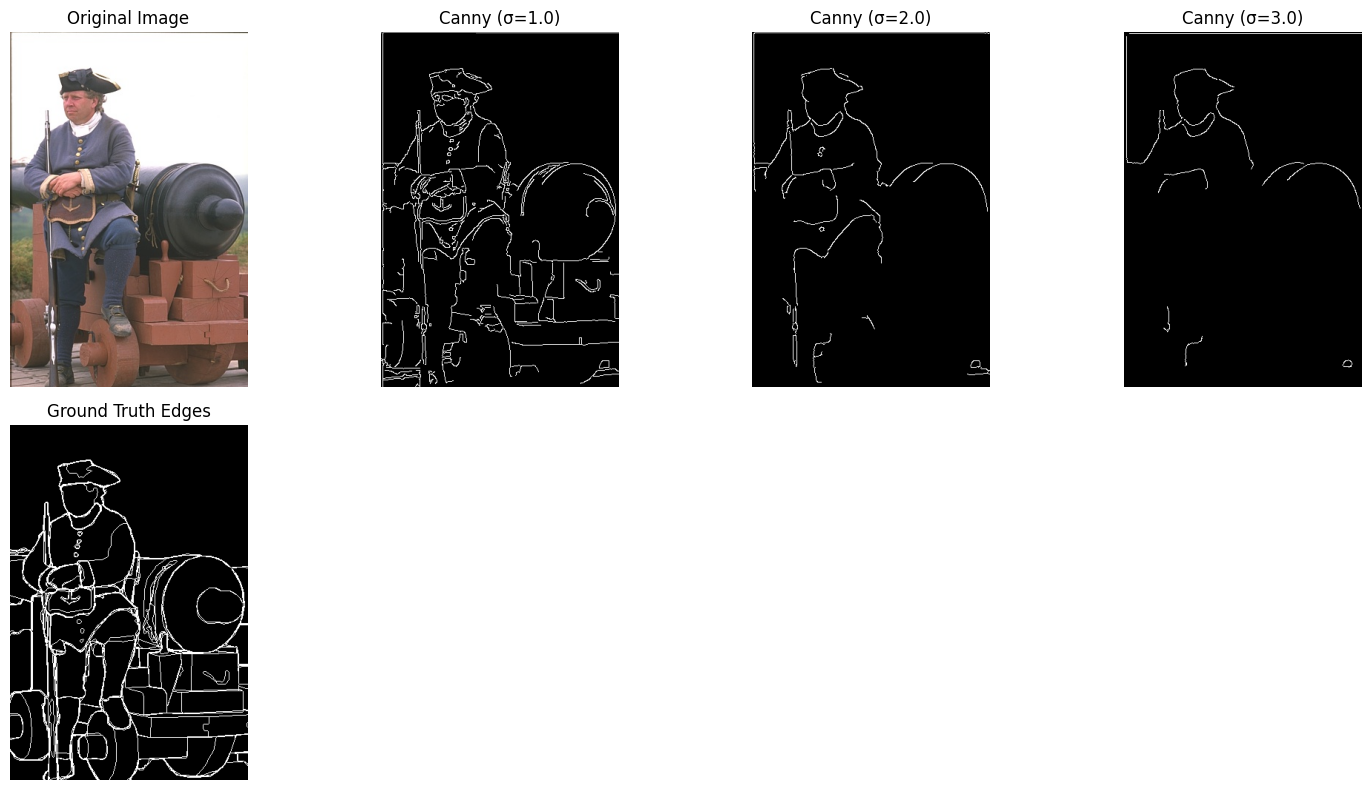

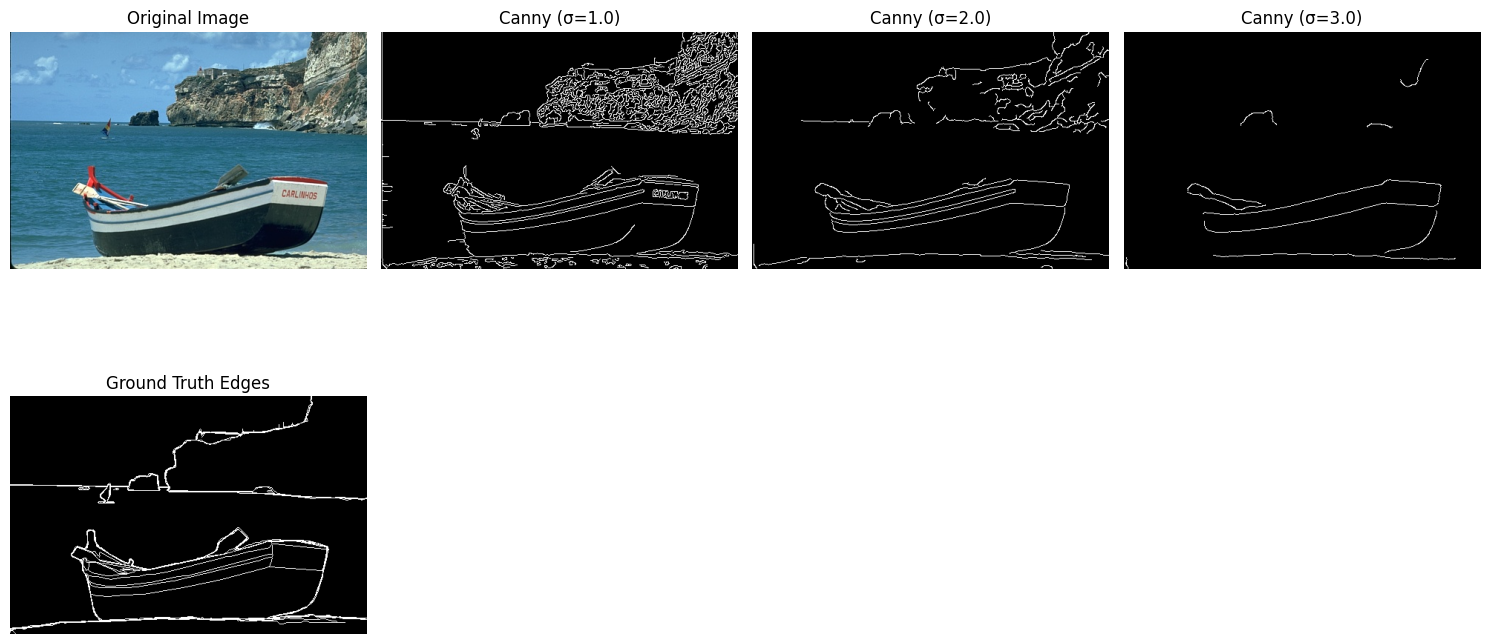

In [34]:
if __name__ == "__main__":
    main() 

## With increase in sigma values for blurring, we move from fine and minute details to higher level details. (Sometimes, by keep increasing the sigma values, we loose the essential edges also.

### Observations:

1. **Sigma = 1.0**: With minimal blurring, the Canny detector captures many details but also detects a significant amount of noise and texture edges that aren't part of the ground truth. It produces thin, precise edges but many of them are unwanted texture details.
2. **Sigma = 2.0**: With moderate blurring, some of the noise is reduced while maintaining most of the important structural edges. This setting provides a better balance between detail preservation and noise suppression.
3. **Sigma = 3.0**: With stronger blurring, more noise is eliminated but some important details are also lost. The edges become smoother and less fragmented, but fine details in the image may be missed.

### Based on metrics table:
- There's a clear trade-off between precision and recall as the sigma value increases. At Sigma 1.0, the Canny edge detector has the highest recall (0.2066) but lowest precision (0.1163), meaning it detects more edges but includes many false positives.
- As sigma increases to 3.0, precision improves significantly (0.3400) while recall drops substantially (0.0630), indicating that higher blur values produce cleaner but fewer detected edges.
- The F1-score, which balances precision and recall, is highest at Sigma 1.0 (0.1489), suggesting this setting provides the best overall performance despite its lower precision.
### Comparison with Ground Truth:

- The ground truth edges represent human consensus about what constitutes meaningful boundaries in the image, focusing on object boundaries and significant structural elements.
- Canny edge detection, being a low-level algorithm, responds to all intensity gradients above certain thresholds, regardless of their semantic importance.
- No single sigma value perfectly matches the ground truth because the Canny detector lacks the semantic understanding that human annotators use to identify meaningful edges.

## Final Conclusion:
    - Effect of Increasing Sigma (Blurring):
        - As the sigma value increases, fine details start disappearing, and only stronger, higher-level edges remain.
        - However, if sigma is too high, even essential edges can disappear, leading to under-detection
    - Canny Edge Detection vs. Ground Truth:
        - Yes, Canny is doing well compared to the Ground Truth because it is designed to find edges effectively usin gradient-based detection, and non-maximum suppression.
## Hence, the Canny edge detection is performing a good job on par with Ground Truth Edges.